In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix, average_precision_score
)
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.utils import resample


In [21]:
#archivo = "Datos\\DatosConYConFeatures.xlsx"
archivo = "..\\Datos\\DatosConYConFeatures - Balanceado.xlsx"

tabla = pd.read_excel(archivo, parse_dates=["timestamp_ventana"])
tabla = tabla.dropna()


In [22]:
#columnas_excluir = ["timestamp", "host", "Y", "reinicio", "falloBruto", "falloPersistente"]
columnas_excluir = ["timestamp_ventana", "host", "Y"]


# Separar clases
clase0 = tabla[tabla["Y"] == 0]
clase1 = tabla[tabla["Y"] == 1]

# Submuestreo de clase 0
clase0_eq = resample(clase0,
                     replace=False,    # no reemplazar
                     n_samples=len(clase1), # mismo tamaño que clase 1
                     random_state=42)

# Dataset balanceado
tabla_eq = pd.concat([clase0_eq, clase1])

#las X serán todas las columnas menos la primera ni última
X = tabla_eq.drop(columns=columnas_excluir)

y = tabla_eq["Y"]

X.shape, y.shape

((808, 22), (808,))

In [23]:
#columnas_excluir = ["timestamp", "host", "Y", "reinicio", "falloBruto", "falloPersistente"]
columnas_excluir = ["timestamp_ventana", "host", "Y"]

X = tabla.drop(columns=columnas_excluir)

y = tabla["Y"]

X.shape, y.shape

((808, 22), (808,))

In [24]:
train_idx = np.load("..\\Utilidades\\indices\\train_idx.npy")
val_idx   = np.load("..\\Utilidades\\indices\\val_idx.npy")
test_idx  = np.load("..\\Utilidades\\indices\\test_idx.npy")


In [25]:
X2d = X.to_numpy().reshape(len(X), -1).astype(np.float32)
X_train, y_train = X2d[train_idx], y[train_idx]
X_val,   y_val   = X2d[val_idx],   y[val_idx]
X_test,  y_test  = X2d[test_idx],  y[test_idx]

X2d


array([[6.0424447e-01, 7.7075183e-01, 2.7599999e-01, ..., 2.8433253e+05,
        3.4861492e+07, 3.5856512e+07],
       [4.3518889e-01, 3.1685814e-01, 2.8933334e-01, ..., 6.4985082e+04,
        3.5870716e+07, 3.6116504e+07],
       [3.7116668e-01, 3.3779871e-02, 3.1833333e-01, ..., 4.7248777e+04,
        3.6119736e+07, 3.6281672e+07],
       ...,
       [3.8636112e-01, 3.2688897e-02, 3.2499999e-01, ..., 3.3471141e+04,
        1.1122571e+08, 1.1134048e+08],
       [4.3142223e-01, 3.0910772e-01, 3.1266665e-01, ..., 4.4414789e+04,
        1.1134298e+08, 1.1150082e+08],
       [3.9958334e-01, 1.8675782e-01, 3.1766668e-01, ..., 3.7959574e+04,
        1.3521062e+08, 1.3533997e+08]], shape=(808, 22), dtype=float32)

In [26]:

from collections import Counter
print("train dist:", Counter(y[train_idx].tolist()))
print("val   dist:", Counter(y[val_idx].tolist()))
print("test  dist:", Counter(y[test_idx].tolist()))

train dist: Counter({1: 195, 0: 183})
val   dist: Counter({0: 101, 1: 86})
test  dist: Counter({1: 123, 0: 120})


In [27]:
X_gs = np.concatenate([X_train, X_val], axis=0)
y_gs = np.concatenate([y_train, y_val], axis=0)
test_fold = np.array([-1]*len(X_train) + [0]*len(X_val))

In [28]:
X_gs = np.concatenate([X_train, X_val], axis=0)
y_gs = np.concatenate([y_train, y_val], axis=0)

test_fold = np.array([-1]*len(X_train) + [0]*len(X_val))
ps = PredefinedSplit(test_fold=test_fold)

params = {
    'criterion': ('gini', 'entropy', 'log_loss'),
    'max_features': ('sqrt', 'log2', None),
    'n_estimators': np.arange(10,101,10)
}
rf = RandomForestClassifier()
clf = GridSearchCV(rf, params, cv=ps,n_jobs=-1)
clf.fit(X_gs, y_gs)

,estimator,RandomForestClassifier()
,param_grid,"{'criterion': ('gini', ...), 'max_features': ('sqrt', ...), 'n_estimators': array([ 10, ...80, 90, 100])}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,"PredefinedSpl...shape=(565,)))"
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,np.int64(60)


In [29]:
print(f'Los mejores hyperparámetros son: {clf.best_params_}, con exactitud de {clf.best_score_}')

Los mejores hyperparámetros son: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': np.int64(60)}, con exactitud de 0.983957219251337


In [30]:
rf_final = RandomForestClassifier(criterion=clf.best_params_['criterion'],
                                  max_features=clf.best_params_['max_features'],
                                  n_estimators=clf.best_params_['n_estimators'])
rf_final.fit(X_train, y_train)

,n_estimators,np.int64(60)
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [31]:
#Métricas para evaluar el modelo
# Predicciones
y_pred = rf_final.predict(X_test)
y_proba = rf_final.predict_proba(X_test)[:,1]  # para ROC-AUC

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9753086419753086
Precision: 0.968
Recall: 0.983739837398374
F1: 0.9758064516129032
ROC-AUC: 0.9961382113821139
Matriz de confusión:
 [[116   4]
 [  2 121]]


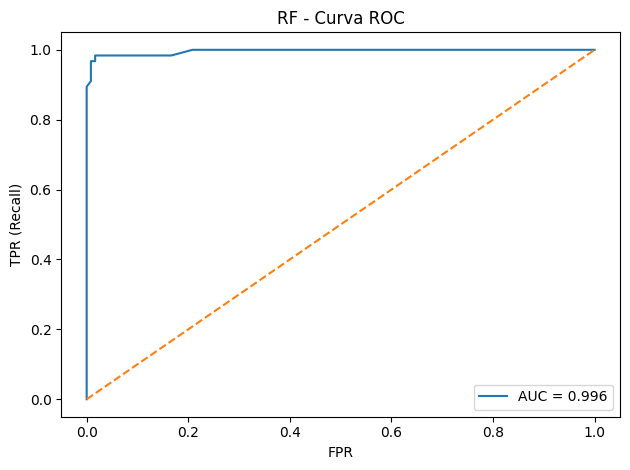

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
auc_roc = roc_auc_score(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("RF - Curva ROC")
plt.legend()
plt.tight_layout()
plt.show()

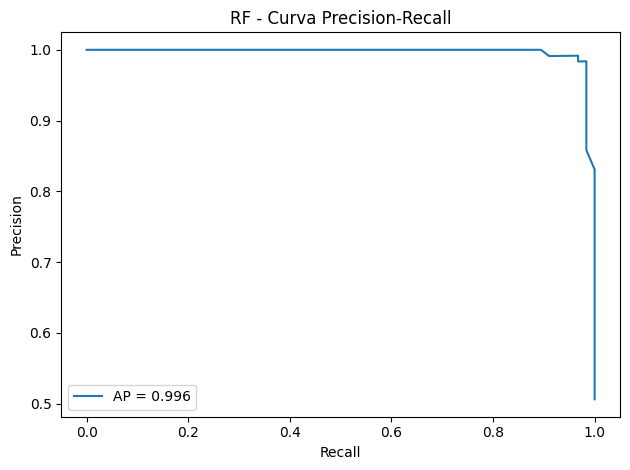

In [33]:
prec, rec, _ = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure()
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("RF - Curva Precision-Recall")
plt.legend()
plt.tight_layout()
plt.show()

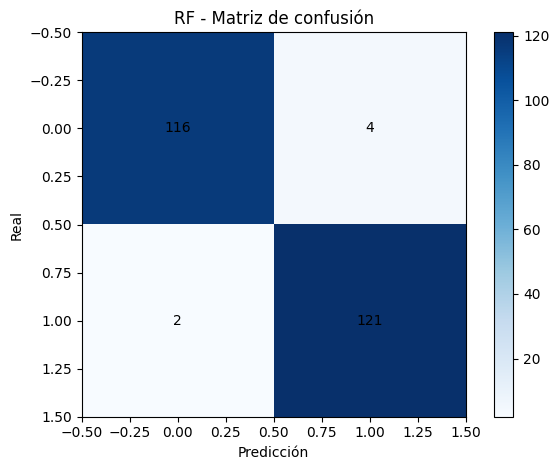

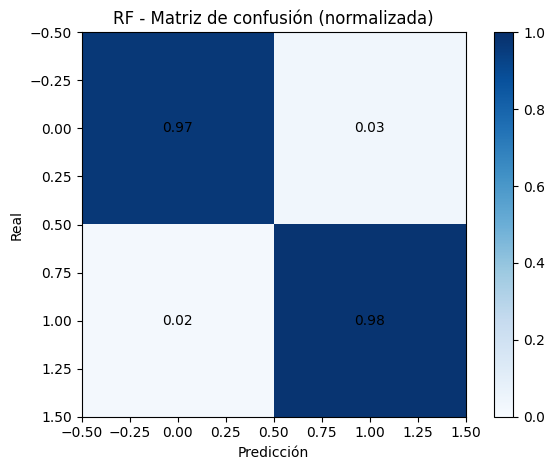

In [34]:
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("RF - Matriz de confusión")
plt.xlabel("Predicción"); plt.ylabel("Real")
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar(); plt.tight_layout(); plt.show()

cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure()
plt.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
plt.title("RF - Matriz de confusión (normalizada)")
plt.xlabel("Predicción"); plt.ylabel("Real")
for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.colorbar(); plt.tight_layout(); plt.show()


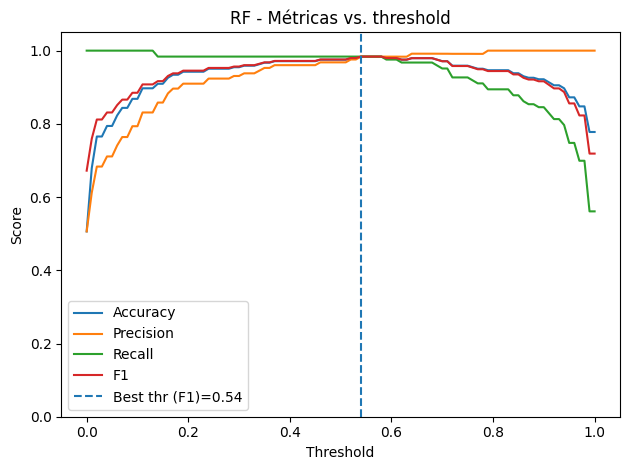

In [35]:
ths = np.linspace(0.0, 1.0, 101)
accs, precs, recs, f1s = [], [], [], []
for t in ths:
    yp = (y_proba >= t).astype(int)
    accs.append(accuracy_score(y_test, yp))
    precs.append(precision_score(y_test, yp, zero_division=0))
    recs.append(recall_score(y_test, yp, zero_division=0))
    f1s.append(f1_score(y_test, yp, zero_division=0))
accs, precs, recs, f1s = map(np.array, (accs, precs, recs, f1s))

best_idx = np.argmax(f1s)
best_thr = ths[best_idx]
plt.figure()
plt.plot(ths, accs, label="Accuracy")
plt.plot(ths, precs, label="Precision")
plt.plot(ths, recs, label="Recall")
plt.plot(ths, f1s, label="F1")
plt.axvline(best_thr, linestyle="--", label=f"Best thr (F1)={best_thr:.2f}")
plt.ylim(0, 1.05)
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("RF - Métricas vs. threshold")
plt.legend(); plt.tight_layout(); plt.show()

In [46]:
#Segunda forma con Cross validator
rfCV = RandomForestClassifier()
clfCV = GridSearchCV(rfCV, params, n_jobs=-1)
clfCV.fit(X_train, y_train)

,estimator,RandomForestClassifier()
,param_grid,"{'criterion': ('gini', ...), 'max_features': ('sqrt', ...), 'n_estimators': array([ 10, ...80, 90, 100])}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,np.int64(50)


In [47]:
print(f'Los mejores hyperparámetros son: {clfCV.best_params_}, con exactitud de {clfCV.best_score_}')

Los mejores hyperparámetros son: {'criterion': 'entropy', 'max_features': None, 'n_estimators': np.int64(50)}, con exactitud de 0.9815087719298246


In [48]:
rf_final_cv = RandomForestClassifier(criterion=clfCV.best_params_['criterion'],
                                  max_features=clfCV.best_params_['max_features'],
                                  n_estimators=clfCV.best_params_['n_estimators'])
rf_final_cv.fit(X_train, y_train)

,n_estimators,np.int64(50)
,criterion,'entropy'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [49]:
#Métricas para evaluar el modelo
# Predicciones
y_cv_pred = rf_final_cv.predict(X_test)
y_cv_proba = rf_final_cv.predict_proba(X_test)[:,1]  # para ROC-AUC

# Métricas
print("Accuracy:", accuracy_score(y_test, y_cv_pred))
print("Precision:", precision_score(y_test, y_cv_pred))
print("Recall:", recall_score(y_test, y_cv_pred))
print("F1:", f1_score(y_test, y_cv_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_cv_pred))
print("Matriz de confusión:\n", confusion_matrix(y_test, y_cv_pred))


Accuracy: 0.9835390946502057
Precision: 0.983739837398374
Recall: 0.983739837398374
F1: 0.983739837398374
ROC-AUC: 0.9835365853658536
Matriz de confusión:
 [[118   2]
 [  2 121]]


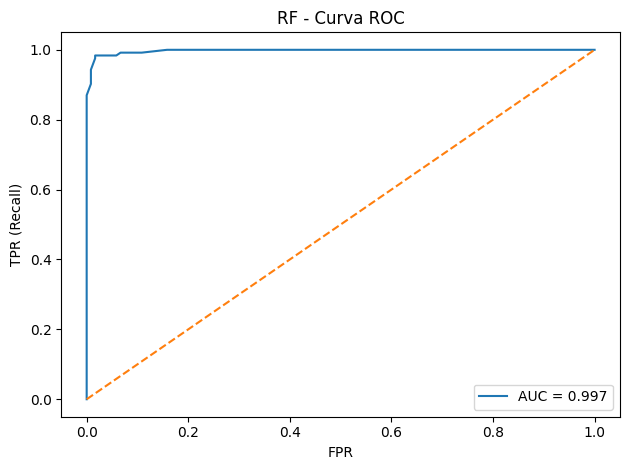

In [50]:
fpr, tpr, _ = roc_curve(y_test, y_cv_proba)
auc_roc = roc_auc_score(y_test, y_cv_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR (Recall)")
plt.title("RF - Curva ROC")
plt.legend()
plt.tight_layout()
plt.show()

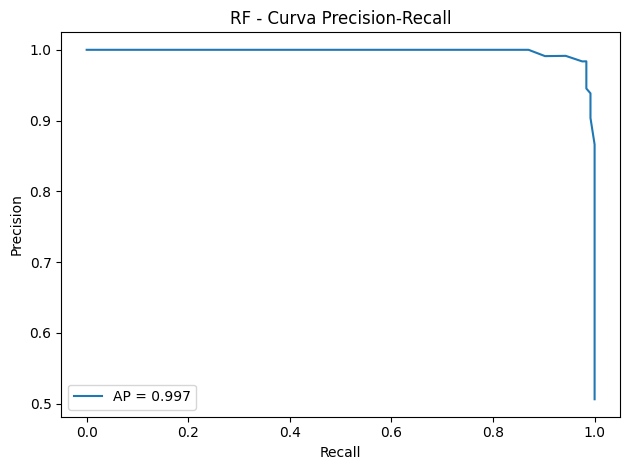

In [51]:
prec, rec, _ = precision_recall_curve(y_test, y_cv_proba)
ap = average_precision_score(y_test, y_cv_proba)
plt.figure()
plt.plot(rec, prec, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("RF - Curva Precision-Recall")
plt.legend()
plt.tight_layout()
plt.show()

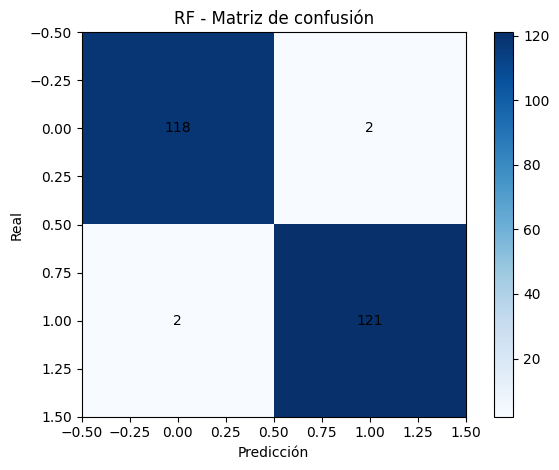

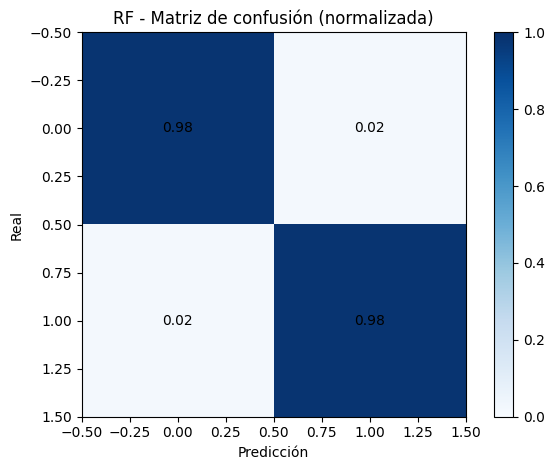

In [52]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_cv_pred)
plt.figure()
plt.imshow(cm, cmap="Blues")
plt.title("RF - Matriz de confusión")
plt.xlabel("Predicción"); plt.ylabel("Real")
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar(); plt.tight_layout(); plt.show()

cm_norm = cm / cm.sum(axis=1, keepdims=True)
plt.figure()
plt.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
plt.title("RF - Matriz de confusión (normalizada)")
plt.xlabel("Predicción"); plt.ylabel("Real")
for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm_norm[i, j]:.2f}", ha="center", va="center")
plt.colorbar(); plt.tight_layout(); plt.show()

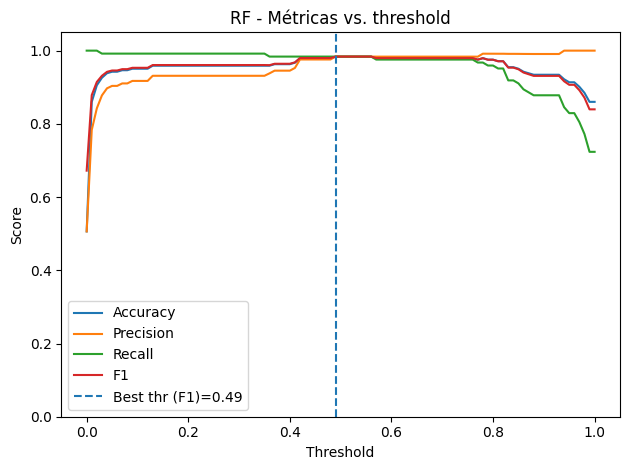

In [ ]:
ths = np.linspace(0.0, 1.0, 101)
accs, precs, recs, f1s = [], [], [], []
for t in ths:
    yp = (y_cv_proba >= t).astype(int)
    accs.append(accuracy_score(y_test, yp))
    precs.append(precision_score(y_test, yp, zero_division=0))
    recs.append(recall_score(y_test, yp, zero_division=0))
    f1s.append(f1_score(y_test, yp, zero_division=0))
accs, precs, recs, f1s = map(np.array, (accs, precs, recs, f1s))

best_idx = np.argmax(f1s)
best_thr = ths[best_idx]
plt.figure()
plt.plot(ths, accs, label="Accuracy")
plt.plot(ths, precs, label="Precision")
plt.plot(ths, recs, label="Recall")
plt.plot(ths, f1s, label="F1")
plt.axvline(best_thr, linestyle="--", label=f"Best thr (F1)={best_thr:.2f}")
plt.ylim(0, 1.05)
plt.xlabel("Threshold"); plt.ylabel("Score")
plt.title("RF - Métricas vs. threshold")
plt.legend(); plt.tight_layout(); plt.show()